In [ ]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import os
from PIL import Image

In [30]:
from os import mkdir


img_path = '../图片/Google-RGB.tif'
img_np = np.array(Image.open(img_path))
img_save_path = '../图片-sam-分割结果/'
mkdir(img_save_path)
img_save_path = os.path.join(img_save_path, os.path.basename(img_path).replace('.tif', '.png'))

img_np.shape
img_np = img_np[:,:,0:3]
img_np.shape

(842, 1049, 3)

In [22]:
sam = sam_model_registry["vit_h"](checkpoint="./sam_vit_h_4b8939.pth").to(device='cuda')
mask_generator = SamAutomaticMaskGenerator(sam, box_nms_thresh=0.9)
masks = mask_generator.generate(img_np)



In [23]:
len(masks) # 29个mask

359

In [24]:
# masks

In [25]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca() # get current axes
    ax.set_autoscale_on(False) # 关闭自动缩放

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    
    # return img
    ax.imshow(img) # 显示图片


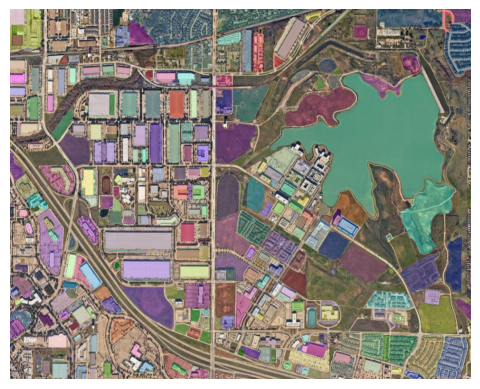

In [26]:
# plt.figure(figsize=(20,20))
plt.imshow(img_np)

show_anns(masks)
plt.axis('off')
plt.show() 
# plt.savefig(img_save_path, bbox_inches='tight', pad_inches=0, dpi=300)

# 保存生成的mask

## 保存彩色mask

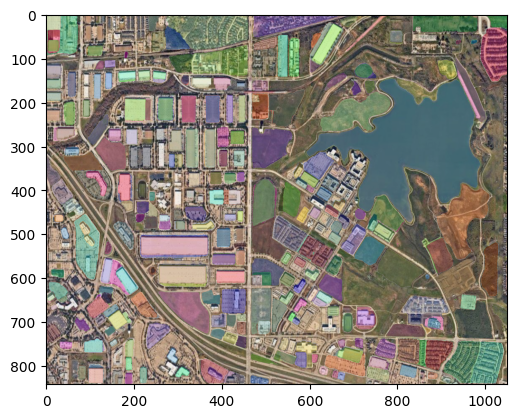

In [38]:
def save_RGB_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    # ax = plt.gca() # get current axes
    # ax.set_autoscale_on(False) # 关闭自动缩放

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    
    # return img
    # ax.imshow(img) # 显示图片
    return img




rgb_mask = save_RGB_anns(masks)
plt.imshow(img_np)
plt.imshow(rgb_mask)
rgb_mask.shape


Image.fromarray((rgb_mask*255).astype(np.uint8)).save(img_save_path)


## 添加geo信息，转png为tif

In [43]:
# from mask_addgeo import mask_with_Geoinfo
import numpy as np
from PIL import Image
from tqdm import tqdm, trange
from ATL_Tools import mkdir_or_exist, find_data_list
from ATL_Tools.ATL_gdal import crop_tif_with_json_nan, Mosaic_all_imgs

import os
from osgeo import gdal
from PIL import Image
Image.MAX_IMAGE_PIXELS = None


def mask_with_Geoinfo(
        MASK_path: str,
        suffix: str,
        MASK_GEO_path: str,
        IMG_path: str,
        backend='gdal'):
    
    """把mask转为RGB图像，并添加坐标信息

    Args:
        MASK_path (str): mask路径
        RGB_path (str): RGB图像路径
        IMG_path (str): 原始图像路径

    Returns:
        None, 生成的RGB图像保存在RGB_path
    """
    mkdir_or_exist(MASK_GEO_path)

    label_suffix = suffix

    # 给生成的RGB图像添加坐标
    add_meta_info = True 

    label_lists = find_data_list(MASK_path, suffix=label_suffix)

    for mask_label_path in tqdm(label_lists, colour='Green'):
        mask_label = np.array(Image.open(mask_label_path)).astype(np.uint8)
        # import pdb; pdb.set_trace()
        # print(mask_label.shape)
        h,w,c = mask_label.shape
        # print(mask_label)
        

        if backend == 'gdal':
            output_path = os.path.join(MASK_GEO_path, os.path.basename(mask_label_path).replace(label_suffix, '.tif'))
            driver = gdal.GetDriverByName('GTiff')
            mask_geo_gdal = driver.Create(output_path, w, h, 3, gdal.GDT_Byte)

            mask_geo_gdal.GetRasterBand(1).WriteArray(mask_label[:,:,0])
            mask_geo_gdal.GetRasterBand(2).WriteArray(mask_label[:,:,1])    
            mask_geo_gdal.GetRasterBand(3).WriteArray(mask_label[:,:,2])

            if add_meta_info:
                IMG_file_path = os.path.join(IMG_path, os.path.basename(mask_label_path).replace(label_suffix, '.tif'))
                IMG_gdal = gdal.Open(IMG_file_path, gdal.GA_ReadOnly)
                assert  IMG_gdal is not None, f"无法打开 {os.path.join(IMG_path, os.path.basename(mask_label_path).replace(label_suffix, '.tif'))}"

                trans = IMG_gdal.GetGeoTransform()
                proj = IMG_gdal.GetProjection()

                mask_geo_gdal.SetGeoTransform(trans)
                mask_geo_gdal.SetProjection(proj)

            mask_geo_gdal = None


MASK_path ='../图片-sam-分割结果/'
MASK_GEO_path = '../图片-sam-分割结果/'
img_path = '../图片-原图/'

mask_with_Geoinfo(MASK_path=MASK_path,
                  suffix='.png',
                  MASK_GEO_path=MASK_GEO_path,
                  IMG_path=img_path,
                  backend='gdal')


--------------------------------------------------------------
-- 正在读取数据集列表... "../图片-sam-分割结果/" 
-- 共在 "../图片-sam-分割结果/" 下寻找到 *.png 1 项
-------------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 36.43it/s]


# 根据mask和分割的label，融合生成最终结果

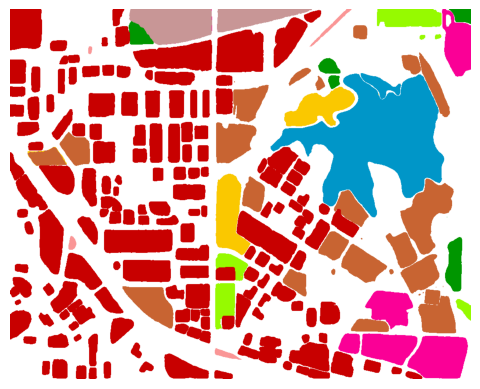

--------------------------------------------------------------
-- 正在读取数据集列表... "../图片-sam融合结果/" 
-- 共在 "../图片-sam融合结果/" 下寻找到 *.png 1 项
-------------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 172.07it/s]


In [56]:
from copy import deepcopy
from tracemalloc import stop
import numpy as np

# img_new =deepcopy(img_np)
img_new = np.full(img_np.shape, 255, dtype=img_np.dtype)

label_path = '../图片-原图/18类分割图像.tif'
img_label  = np.array(Image.open(label_path))
img_label = cv2.resize(img_label, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)


for index in range(len(masks)):
    mask_pos = masks[index]['segmentation']  # True 和 False
    
    # 这里不应该去算平均值，而应该去找，当前mask中，占比最大的值。

    R_channel_list = []
    G_channel_list = []
    B_channel_list = []
    RGB_list = []

    R_channel_list=list(img_label[:,:,0][mask_pos])
    G_channel_list=list(img_label[:,:,1][mask_pos])
    B_channel_list=list(img_label[:,:,2][mask_pos])


    for R,G,B in zip(R_channel_list, G_channel_list, B_channel_list):
        RGB_list.append(list([R,G,B]))

    # 统计RGB_list中出现次数最多的元素

    RGB_list_unique = np.unique(RGB_list, axis=0)
    RGB_list_count = [0 for RGB in RGB_list_unique]
    for RGB in RGB_list:
        for index in range(len(RGB_list_unique)):
                # print(RGB == RGB_list_unique[index])
            if RGB[0] == RGB_list_unique[index][0] and RGB[1] == RGB_list_unique[index][1] and RGB[2] == RGB_list_unique[index][2]:
                RGB_list_count[index] += 1
            
    max_index = RGB_list_count.index(max(RGB_list_count))
    # print(RGB_list_count, RGB_list_unique[max_index])
    # print(max_index)
    # break


    R_channel= RGB_list_unique[max_index][0]
    G_channel= RGB_list_unique[max_index][1]
    B_channel= RGB_list_unique[max_index][2]
    img_new[mask_pos]= [R_channel, G_channel, B_channel]
    # print(R_channel_mean,G_channel_mean,B_channel_mean)


# edge_mask = cv2.Canny(cv2.cvtColor(img_label, cv2.COLOR_RGB2GRAY), 100, 200)
# # 让edge_mask中的True和False翻一下

# # edge_color=[0,0,0]
# # img_new[edge_mask==255] = edge_color

# # img_add_img_mask = cv2.addWeighted(img_np, 0.1, img_new, 0.5, 0)

# # plt.imshow(img_np)
# # plt.show()
# # plt.imshow(img_new)
# # plt.show()
plt.imshow(img_new)
plt.axis('off')
plt.show()

img_save_path = '../图片-sam融合结果/'
mkdir_or_exist(img_save_path)

label_save_path = os.path.join(img_save_path, os.path.basename(label_path).replace('.tif', '.png'))

img_label  = np.array(Image.open(label_path))
img_new = cv2.resize(img_new, (img_label.shape[1], img_label.shape[0]), interpolation=cv2.INTER_NEAREST)
# print(img_np.shape)
# print(img_new.shape)



Image.fromarray(img_new).save(label_save_path)

MASK_path ='../图片-sam融合结果/'
mask_with_Geoinfo(MASK_path=MASK_path, 
                  suffix='.png', 
                  MASK_GEO_path=MASK_path, 
                  IMG_path='../图片-原图/', 
                  backend='gdal')

